In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
from tensorflow.python import tf2
# if not tf2.enabled():
#   import tensorflow.compat.v2 as tf
#   tf.enable_v2_behavior()
#   assert tf2.enabled()

#import tensorflow_datasets as tfds
from tensorflow.keras.datasets import mnist
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# load and prepare data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

n_train, n_test = 45000, 4000
x_train = x_train[:n_train,:,:,np.newaxis]
x_test = x_test[:n_test,:,:,np.newaxis]
y_train, y_test = y_train[:n_train], y_test[:n_test]

#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(45000, 28, 28, 1)
(4000, 28, 28, 1)


In [4]:
#@title Image Plot Util
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(1.5*n, 1.5))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

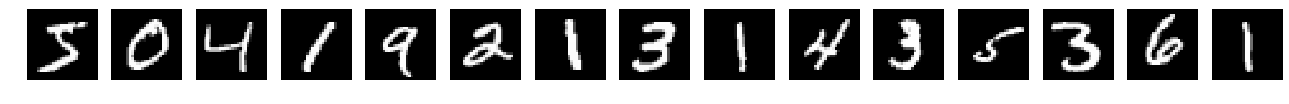

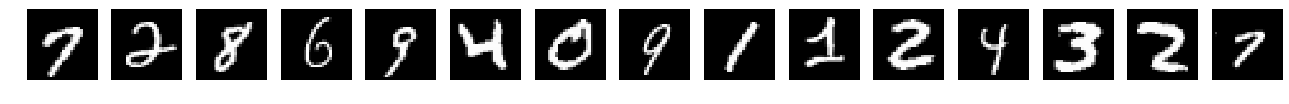

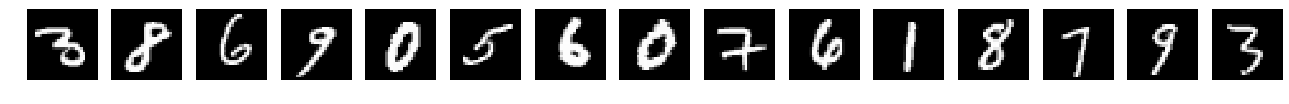

In [5]:
display_imgs(x_train[:15])
display_imgs(x_train[15:30])
display_imgs(x_train[30:45])

# Full VAE

In [6]:
x_train.shape, x_test.shape

((45000, 28, 28, 1), (4000, 28, 28, 1))

In [7]:
input_shape = x_train.shape[1:]#datasets_info.features['image'].shape
encoded_size = 2
base_depth = 16

In [8]:
alpha = 1 #prior variance

In [9]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=alpha),
                        reinterpreted_batch_ndims=1)

In [10]:
beta = 1 #weight of KL loss

In [11]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
#    tfkl.Dense(encoded_size)
    tfpl.MultivariateNormalTriL(
        encoded_size,
    activity_regularizer= tfpl.KLDivergenceRegularizer(prior, weight=beta)),
])

In [12]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

In [13]:
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

In [14]:
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        6416      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          25632     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 8)           12552     
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0

In [15]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

vae.fit(x_train, x_train,
        epochs= 8, batch_size=32,
        validation_data= (x_test,x_test))

Train on 45000 samples, validate on 4000 samples
Epoch 1/8
45000/45000 [==============================] - 112s 2ms/sample - loss: 182.3854 - val_loss: 165.0983
Epoch 2/8
45000/45000 [==============================] - 107s 2ms/sample - loss: 164.2734 - val_loss: 164.0352
Epoch 3/8
45000/45000 [==============================] - 109s 2ms/sample - loss: 161.0541 - val_loss: 158.3871
Epoch 4/8
45000/45000 [==============================] - 110s 2ms/sample - loss: 159.0428 - val_loss: 157.9488
Epoch 5/8
45000/45000 [==============================] - 104s 2ms/sample - loss: 157.6075 - val_loss: 157.4934
Epoch 6/8
45000/45000 [==============================] - 105s 2ms/sample - loss: 156.8158 - val_loss: 155.4022
Epoch 7/8
45000/45000 [==============================] - 105s 2ms/sample - loss: 156.0207 - val_loss: 154.6874
Epoch 8/8
45000/45000 [==============================] - 106s 2ms/sample - loss: 155.4273 - val_loss: 155.9155


In [16]:
x = x_test[np.random.choice(n_test, 13, replace=False)]
xhat = vae(x)

Originals:


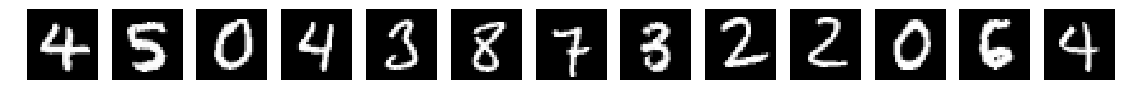

Decoded Random Samples:


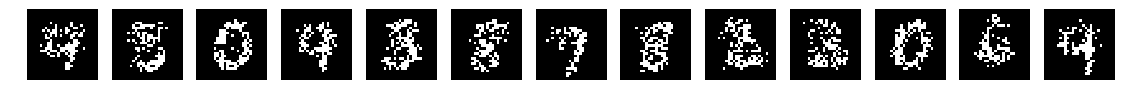

Decoded Modes:


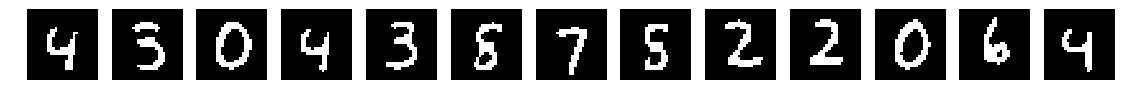

Decoded Means:


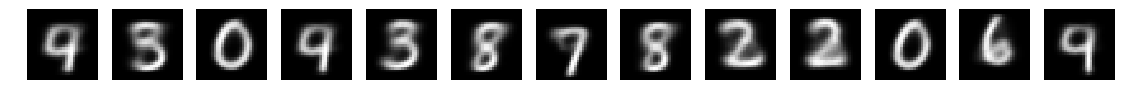

In [17]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

In [18]:
x_encoded = encoder(x_test).mean()

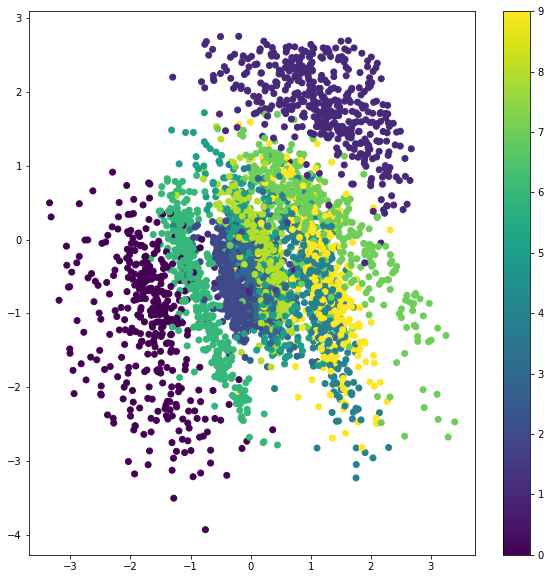

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(x_encoded[:, 0], x_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

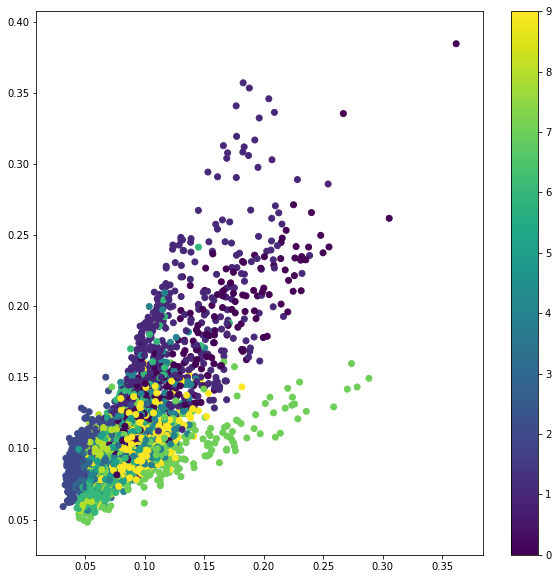

In [31]:
x_encoded_std = encoder(x_test).stddev()
plt.figure(figsize=(10, 10))
plt.scatter(x_encoded_std[:, 0], x_encoded_std[:, 1], c=y_test)
plt.colorbar()
plt.show()

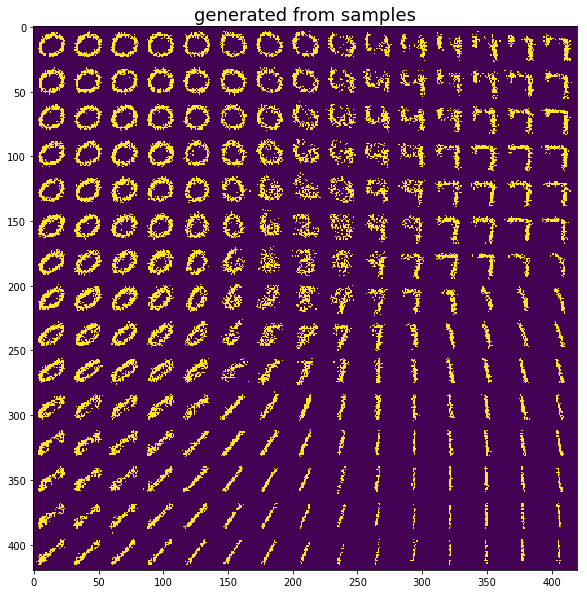

In [20]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-5, 5] standard deviations
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) #* epsilon_std
        x_decoded = decoder(z_sample.astype('float32'))
        x_decoded = np.array(x_decoded.sample())
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title('generated from samples', size=18)
plt.imshow(figure)
plt.show()

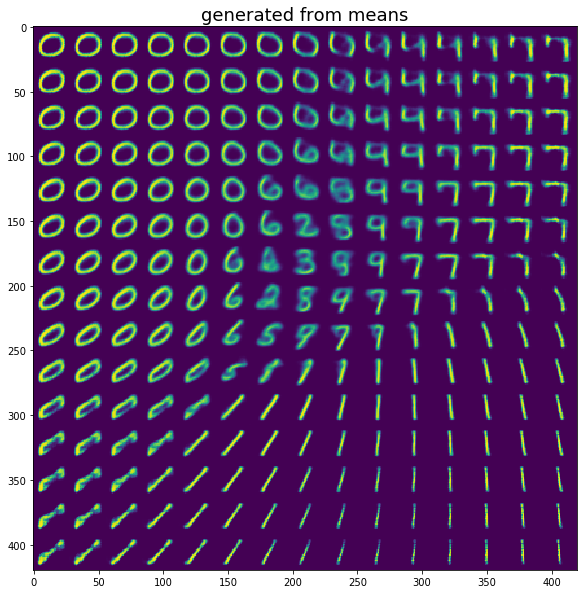

In [21]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-5, 5] standard deviations
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) #* epsilon_std
        x_decoded = decoder(z_sample.astype('float32'))
        x_decoded = np.array(x_decoded.mean())
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title('generated from means', size=18)
plt.imshow(figure)
plt.show()

# Deterministic AE

In [22]:
encoder2 = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfkl.Dense(encoded_size)
#     tfpl.MultivariateNormalTriL(
#         encoded_size,
#     activity_regularizer= tfpl.KLDivergenceRegularizer(prior, weight=beta)),
])

In [23]:
decoder2 = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

In [24]:
vae2 = tfk.Model(inputs=encoder2.inputs,
                outputs=decoder2(encoder2.outputs[0]))

In [25]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae2.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

vae2.fit(x_train, x_train,
        epochs= 7, batch_size=32,
        validation_data= (x_test,x_test))

Train on 45000 samples, validate on 4000 samples
Epoch 1/7
45000/45000 [==============================] - 105s 2ms/sample - loss: 177.4288 - val_loss: 154.8251
Epoch 2/7
45000/45000 [==============================] - 104s 2ms/sample - loss: 153.3008 - val_loss: 149.5850
Epoch 3/7
45000/45000 [==============================] - 106s 2ms/sample - loss: 147.8490 - val_loss: 146.9579
Epoch 4/7
45000/45000 [==============================] - 116s 3ms/sample - loss: 145.0296 - val_loss: 143.9331
Epoch 5/7
45000/45000 [==============================] - 115s 3ms/sample - loss: 143.3662 - val_loss: 145.2246
Epoch 6/7
45000/45000 [==============================] - 117s 3ms/sample - loss: 141.8420 - val_loss: 141.7391
Epoch 7/7
45000/45000 [==============================] - 110s 2ms/sample - loss: 141.0820 - val_loss: 142.2881


Originals:


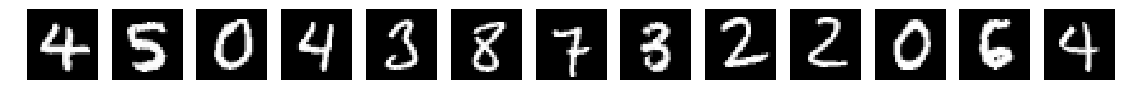

Decoded Random Samples:


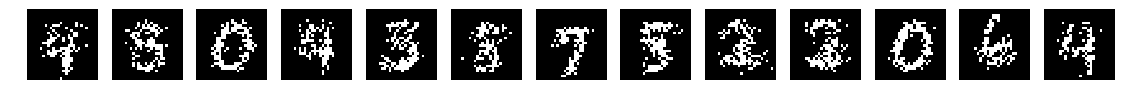

Decoded Modes:


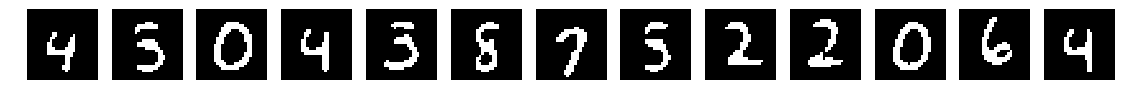

Decoded Means:


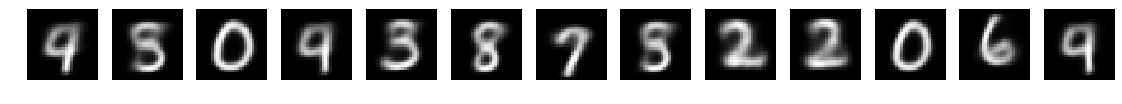

In [26]:
xhat = vae2(x)

print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

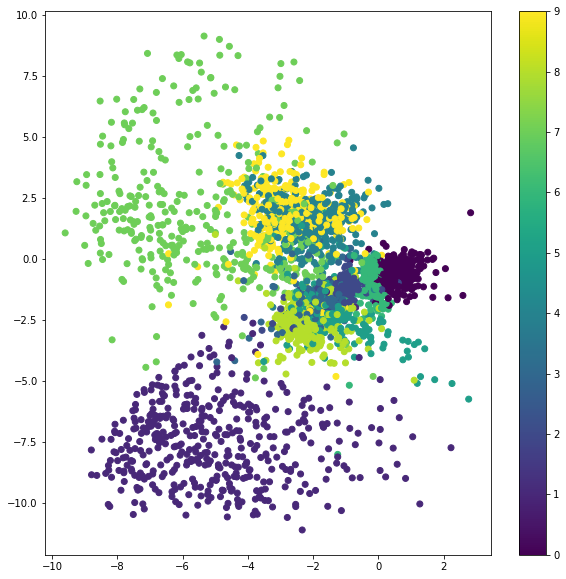

In [27]:
x_encoded = encoder2(x_test)#.mean()
plt.figure(figsize=(10, 10))
plt.scatter(x_encoded[:, 0], x_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

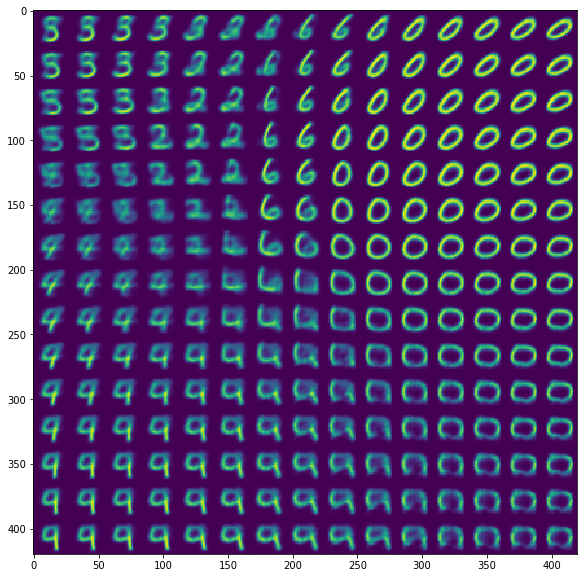

In [32]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-5, 5] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) #* epsilon_std
        x_decoded = decoder2(z_sample.astype('float32'))
        x_decoded = np.array(x_decoded.mean())
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()